# **🎓Tugas Pra-UTS Klasifikasi Gambar Menggunakan Model Klasik**

#### **Praktikum Machine Learning**
#### **Nama Anggota 1:   Amanda Putri Aprilliani (105222001)**
#### **Nama Anggota 2:   Anom Wajawening (105222035)**
#### **Tanggal:          15 April 2025**


============================================================================================

### 📝 **Deskripsi Tugas**
Tugas ini bertujuan untuk menerapkan metode klasifikasi pada data gambar menggunakan salah satu model klasik berikut:
- Decision Tree
- Random Forest (Tree)
- K-Nearest Neighbor (KNN)
- Support Vector Machine (SVM) ->> YANG AKAN DIPILIH PADA TUGAS KELOMPOK KAMI KALI INI

============================================================================

### 0. Import Library

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from skimage.transform import resize
from skimage.io import imread
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from skimage.feature import hog

## **1. 📊 EDA (Exploratory Data Analysis)**

In [19]:
# Persiapan Dataset

# Menentukan direktori dataset
anemic_folder = 'anemic'
nonanemic_folder = 'nonanemic'


### 1.1 Deskripsi Dataset

In [20]:
print ("===== DESKRIPSI DATASET =====") 
num_anemic = len(os.listdir(anemic_folder))
num_nonanemic = len(os.listdir(nonanemic_folder))
total_images = num_anemic + num_nonanemic

print ("Jumlah gambar anemic: ", num_anemic)
print ("Jumlah gambar non-anemic: ", num_nonanemic)
print ("Total gambar: ", total_images)
print(f"Rasio anemic:nonanemic = {num_anemic/total_images:.2f}:{num_nonanemic/total_images:.2f}")

===== DESKRIPSI DATASET =====
Jumlah gambar anemic:  2563
Jumlah gambar non-anemic:  1714
Total gambar:  4277
Rasio anemic:nonanemic = 0.60:0.40


### 1.2 Distribusi Kelas

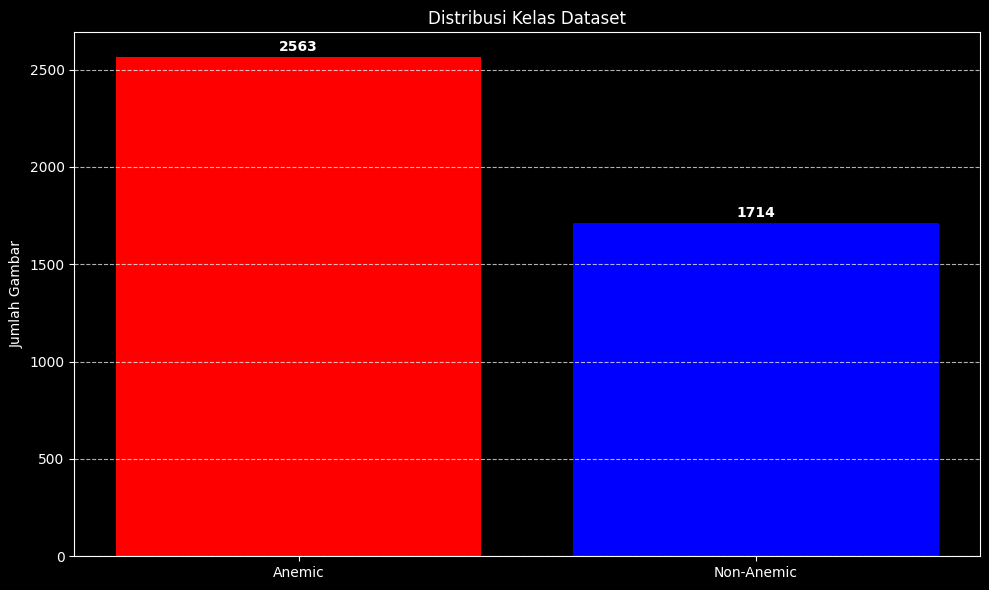

In [ ]:
# Distribusi kelas ini digunakan untuk mengetahui jumlah gambar dari masing-masing kelas dalam dataset.

plt.figure(figsize=(10, 6))
plt.bar(['Anemic', 'Non-Anemic'], [num_anemic, num_nonanemic], color=['red', 'blue'])
plt.title('Distribusi Kelas Dataset')
plt.ylabel('Jumlah Gambar')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i,v in enumerate([num_anemic, num_nonanemic]):
    plt.text(i, v + 30, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('distribusi_kelas.png', dpi=300)
plt.show()

### 1.3 Visualisasi Sampel Gambar

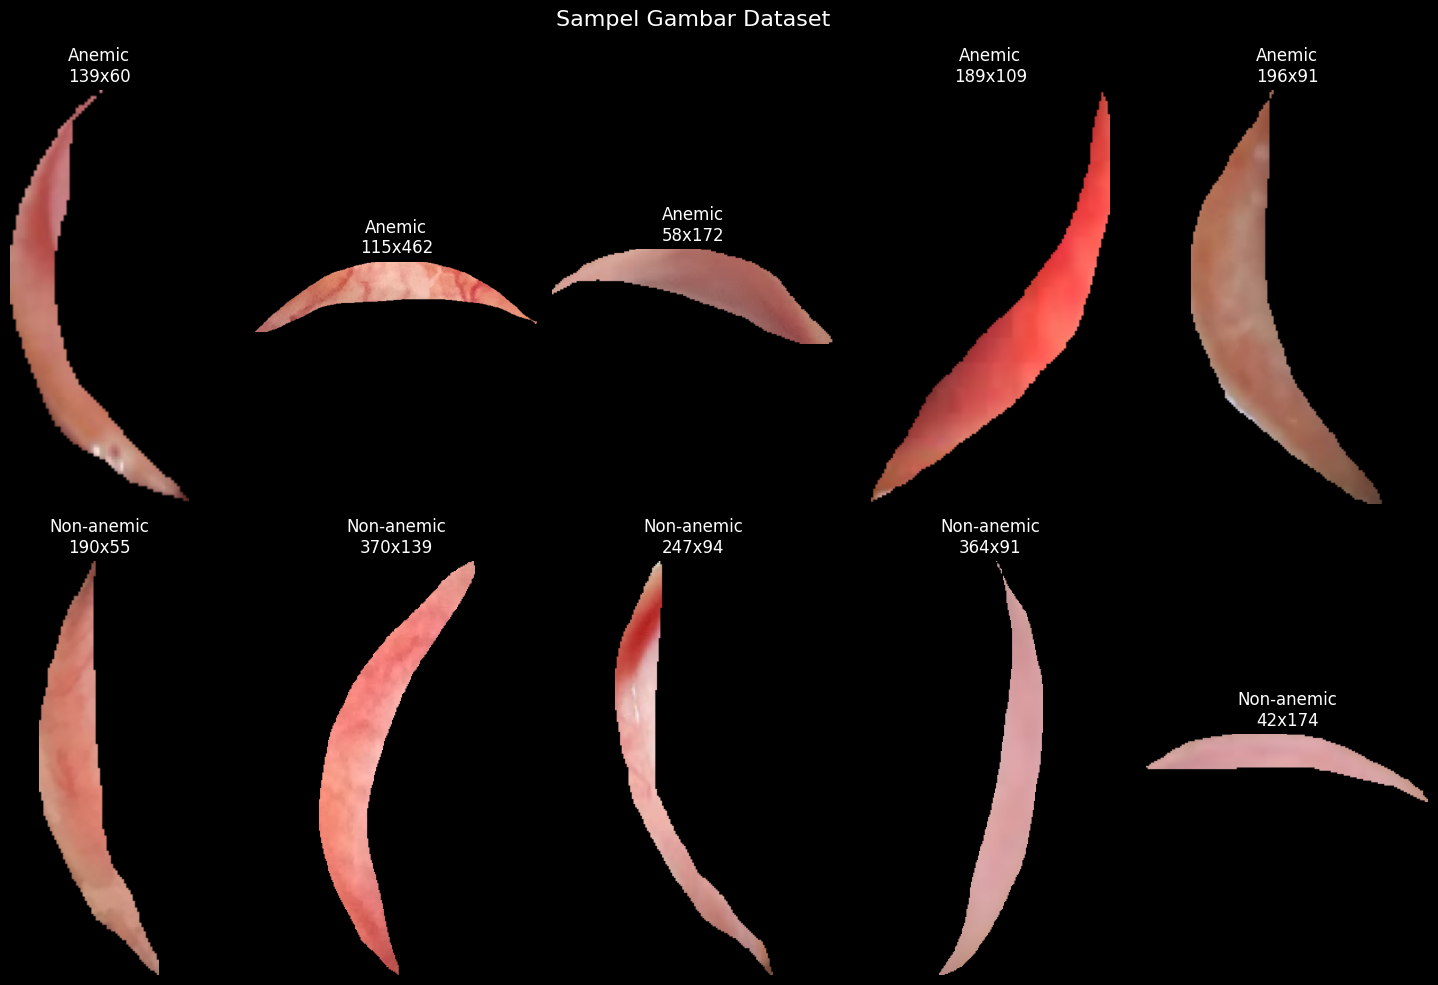

In [ ]:
# Visualisasi sampel gambar ini digunakan untuk menampilkan beberapa gambar dari masing-masing kelas dalam dataset.

def visualize_sample_images(anemic_folder, nonanemic_folder, num_samples=5, random_state=None):
    """
    Visualisasi sampel gambar dari kedua kelas
    
    Parameters:
    -----------
    anemic_folder : str
        Path ke folder gambar anemic
    nonanemic_folder : str
        Path ke folder gambar non-anemic
    num_samples : int
        Jumlah sampel dari setiap kelas
    random_state : int
        Random seed untuk reproducibility
    """
    if random_state is not None:
        random.seed(random_state)
    
    # List file dari kedua kelas
    anemic_files = os.listdir(anemic_folder)
    nonanemic_files = os.listdir(nonanemic_folder)
    
    # Pilih sampel secara acak 
    if len(anemic_files) > num_samples:
        anemic_files = random.sample(anemic_files, num_samples)
    
    if len(nonanemic_files) > num_samples:
        nonanemic_files = random.sample(nonanemic_files, num_samples)
    
    # Buat figure
    fig = plt.figure(figsize=(15, 10))
    plt.suptitle("Sampel Gambar Dataset", fontsize=16)
    
    # Plot gambar anemic
    for i, filename in enumerate(anemic_files):
        plt.subplot(2, num_samples, i+1)
        img_path = os.path.join(anemic_folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
            plt.imshow(img)
            plt.title(f"Anemic\n{img.shape[0]}x{img.shape[1]}")
            plt.axis('off')
    
    # Plot gambar non-anemic
    for i, filename in enumerate(nonanemic_files):
        plt.subplot(2, num_samples, num_samples+i+1)
        img_path = os.path.join(nonanemic_folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            plt.imshow(img)
            plt.title(f"Non-anemic\n{img.shape[0]}x{img.shape[1]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    return fig

fig = visualize_sample_images(anemic_folder, nonanemic_folder, num_samples=5, random_state=42)
plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

### 1.4 Analisis Dimensi dan Format Gambar

In [23]:
# Analisis dimensi dan format gambar diperlukan untuk memahami variasi ukuran dan format gambar dalam dataset.

print("\n===== ANALISIS DIMENSI DAN FORMAT =====")

# Fungsi untuk menganalisis dimensi dan format gambar
def analyze_image_dimensions(folder_path, limit=100):
    widths, heights = [], []
    formats = {}
    sizes = []
    
    files = os.listdir(folder_path)[:limit]
    for filename in tqdm(files, desc=f"Menganalisis gambar di {folder_path}"):
        file_path = os.path.join(folder_path, filename)
        try:
            # Mendapatkan format gambar
            format_type = filename.split('.')[-1].lower()
            formats[format_type] = formats.get(format_type, 0) + 1
            
            # Mendapatkan dimensi
            img = Image.open(file_path)
            width, height = img.size
            widths.append(width)
            heights.append(height)
            
            # Mendapatkan ukuran file
            size_kb = os.path.getsize(file_path) / 1024  # KB
            sizes.append(size_kb)
            
        except Exception as e:
            print(f"Error dengan file {filename}: {e}")
    
    return {
        'widths': widths,
        'heights': heights,
        'formats': formats,
        'sizes': sizes
    }

# Menganalisis subset dari kedua folder
anemic_stats = analyze_image_dimensions(anemic_folder, limit=100)
nonanemic_stats = analyze_image_dimensions(nonanemic_folder, limit=100)

# Menampilkan statistik dimensi
print("\nStatistik Dimensi Gambar Anemic:")
print(f"Width - Min: {min(anemic_stats['widths'])}, Max: {max(anemic_stats['widths'])}, Mean: {np.mean(anemic_stats['widths']):.2f}")
print(f"Height - Min: {min(anemic_stats['heights'])}, Max: {max(anemic_stats['heights'])}, Mean: {np.mean(anemic_stats['heights']):.2f}")
print(f"Ukuran File (KB) - Min: {min(anemic_stats['sizes']):.2f}, Max: {max(anemic_stats['sizes']):.2f}, Mean: {np.mean(anemic_stats['sizes']):.2f}")

print("\nStatistik Dimensi Gambar Non-anemic:")
print(f"Width - Min: {min(nonanemic_stats['widths'])}, Max: {max(nonanemic_stats['widths'])}, Mean: {np.mean(nonanemic_stats['widths']):.2f}")
print(f"Height - Min: {min(nonanemic_stats['heights'])}, Max: {max(nonanemic_stats['heights'])}, Mean: {np.mean(nonanemic_stats['heights']):.2f}")
print(f"Ukuran File (KB) - Min: {min(nonanemic_stats['sizes']):.2f}, Max: {max(nonanemic_stats['sizes']):.2f}, Mean: {np.mean(nonanemic_stats['sizes']):.2f}")

print("\nFormat Gambar Anemic:")
for fmt, count in anemic_stats['formats'].items():
    print(f"{fmt}: {count}")

print("\nFormat Gambar Non-anemic:")
for fmt, count in nonanemic_stats['formats'].items():
    print(f"{fmt}: {count}")


===== ANALISIS DIMENSI DAN FORMAT =====


Menganalisis gambar di nonanemic: 100%|██████████| 100/100 [00:00<00:00, 1018.97it/s]


Statistik Dimensi Gambar Anemic:
Width - Min: 87, Max: 462, Mean: 267.67
Height - Min: 87, Max: 462, Mean: 260.73
Ukuran File (KB) - Min: 11.45, Max: 39.99, Mean: 28.20

Statistik Dimensi Gambar Non-anemic:
Width - Min: 49, Max: 499, Mean: 194.36
Height - Min: 49, Max: 499, Mean: 193.68
Ukuran File (KB) - Min: 4.96, Max: 58.80, Mean: 18.60

Format Gambar Anemic:
png: 100

Format Gambar Non-anemic:
png: 100


### 1.5 Analisis Warna (RGB)

Menganalisis warna di nonanemic: 100%|██████████| 20/20 [00:00<00:00, 458.08it/s]
C:\Users\user\AppData\Local\Temp\ipykernel_12432\2627096001.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(anemic_colors[channel], color=colors[i], shade=True, label='Anemic')
C:\Users\user\AppData\Local\Temp\ipykernel_12432\2627096001.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonanemic_colors[channel], color='gray', shade=True, label='Non-anemic')
C:\Users\user\AppData\Local\Temp\ipykernel_12432\2627096001.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(anemic_colors[channel], color=colors[i], shade=True, label='Anemi

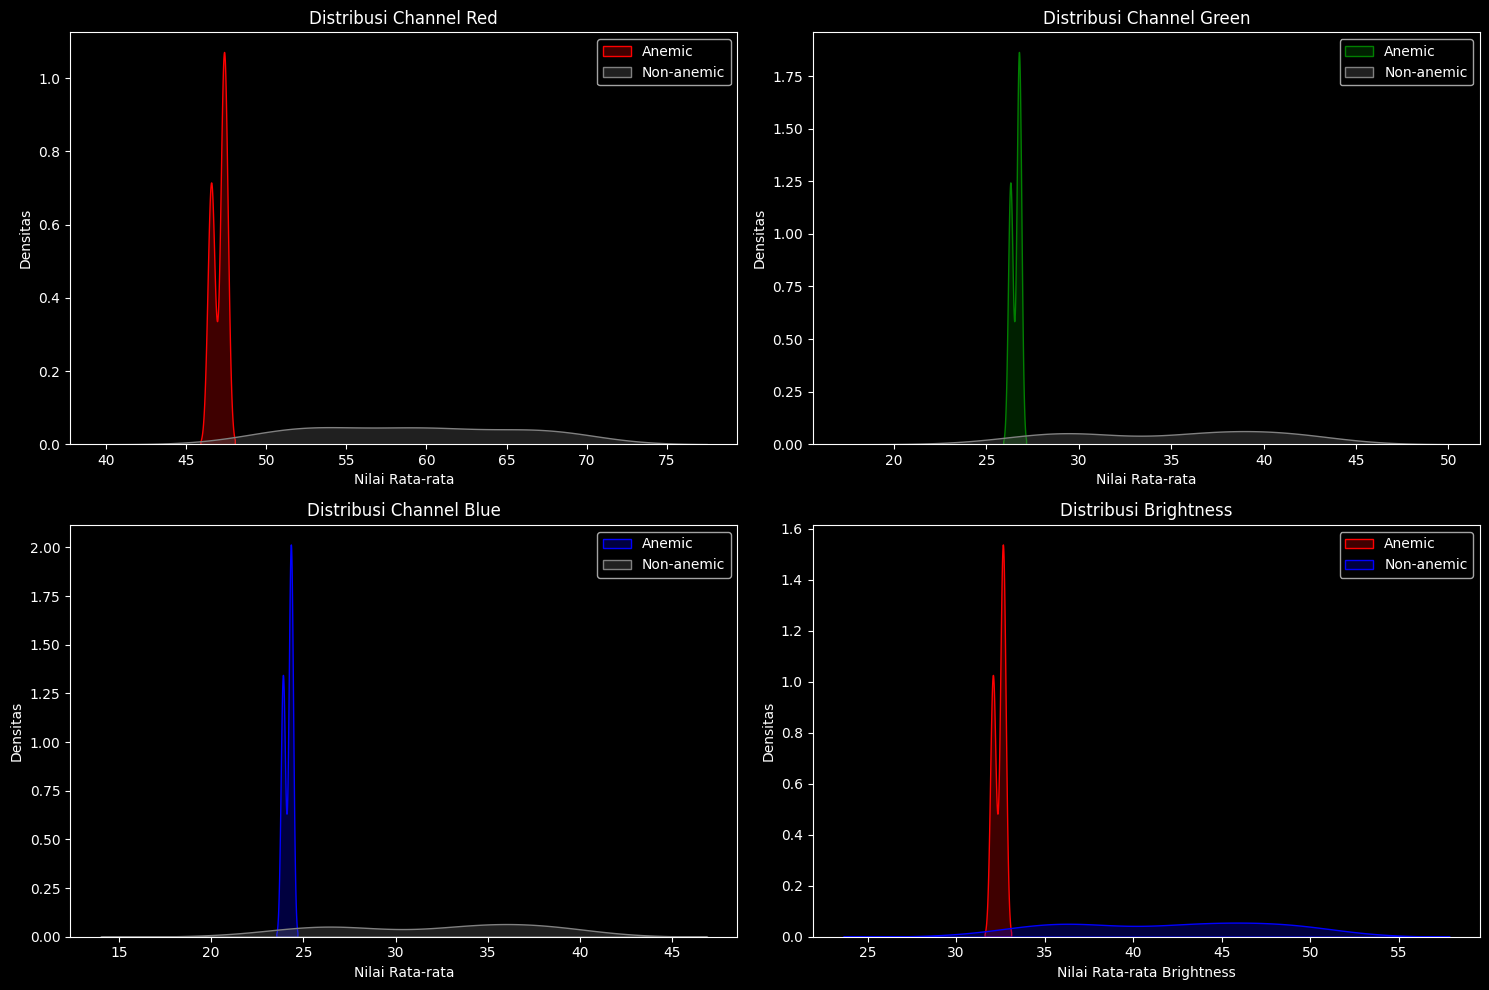

In [24]:
# Menganalisis warna dan kecerahan dalam gambar ini digunakan untuk memahami distribusi warna dalam dataset dan tingkat kecerahannya. Hal ini penting untuk analisis lebih lanjut dan pemrosesan gambar.

def analyze_color_distribution(folder_path, num_samples=20):
    r_means, g_means, b_means = [], [], []
    brightness_means = []
    
    files = os.listdir(folder_path)[:num_samples]
    for filename in tqdm(files, desc=f"Menganalisis warna di {folder_path}"):
        img_path = os.path.join(folder_path, filename)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                # Pisahkan channel RGB
                b, g, r = cv2.split(img)  
                
                # Rata-rata per channel
                r_means.append(np.mean(r))
                g_means.append(np.mean(g))
                b_means.append(np.mean(b))
                
                # Rata-rata brightness
                brightness = 0.299 * r + 0.587 * g + 0.114 * b 
                brightness_means.append(np.mean(brightness))
        except Exception as e:
            print(f"Error dengan file {filename}: {e}")
    
    return {
        'red': r_means,
        'green': g_means,
        'blue': b_means,
        'brightness': brightness_means
    }

anemic_colors = analyze_color_distribution(anemic_folder)
nonanemic_colors = analyze_color_distribution(nonanemic_folder)

# Visualisasi distribusi warna
plt.figure(figsize=(15, 10))

# Plot distribusi RGB
channels = ['red', 'green', 'blue']
colors = ['red', 'green', 'blue']

for i, channel in enumerate(channels):
    plt.subplot(2, 2, i+1)
    
    sns.kdeplot(anemic_colors[channel], color=colors[i], shade=True, label='Anemic')
    sns.kdeplot(nonanemic_colors[channel], color='gray', shade=True, label='Non-anemic')
    
    plt.title(f'Distribusi Channel {channel.capitalize()}')
    plt.xlabel('Nilai Rata-rata')
    plt.ylabel('Densitas')
    plt.legend()

# Plot distribusi brightness
plt.subplot(2, 2, 4)
sns.kdeplot(anemic_colors['brightness'], color='red', shade=True, label='Anemic')
sns.kdeplot(nonanemic_colors['brightness'], color='blue', shade=True, label='Non-anemic')
plt.title('Distribusi Brightness')
plt.xlabel('Nilai Rata-rata Brightness')
plt.ylabel('Densitas')
plt.legend()

plt.tight_layout()
plt.savefig('color_distribution.png')
plt.show()

### 1.5 Insight dari EDA

#### **Insight dari Deskripsi Dataset**
##### Terdapat total 4277 dari gambar anemic dan nonanemic yang cukup baik untuk model klasifikasi klasik seperti SVM. Perbandingan jumlah gambar anemic dan nonanemic yang cukup signifikan menunjukkan terdapat ketidaseimbangan ringan dengan rasio 60% gambar anemic dan 40% gambar nonanemic.

#### **Insight dari Analisis Dimensi dan Format Gambar**
##### 1. Variasi ukuran yang beragam. Gambar anemic memiliki rentang dimensi dari 87x87 piksel hingga 462x462 piksel sedangkan gambar nonanemic memiliki rentamg yang lebih lebar yaitu dari 49x49 piksel sampai 499x499 piksel. Hal ini menunjukkan perlu adanya standardisasi ukuran pemrosesan lanjutan
##### 2. Ukuran file. Gambar anemic rata-rata memiliki ukuran file yang lebih besar (28.20KB) dibandingkan nonanemic yaitu 18.60 KB. Hal ini bisa menunjukkan adanya kompleksitas visual atau detail dalam gambar anemic.
##### 3. Semua format dalam PNG, yang berarti bagus karena tidak perlu adanya penanganan khusus untuk gambar format beda.

#### **Insight dari Analisis Warna RGB dan Kecerahan**
##### 1. Dilihat dari grafik, gambar anemic memiliki puncak tajam (area dimana banyak gambar memiliki nilai intensitas warna yang sangat mirip) yang lebih rendah daripada gambar nonanemic. Hal ini menunjukkan gambar anemic TIDAK lebih berwarna dari nonanemic. Gambar anemic menunjukkan keseragaman warna yang lebih tinggi sedangkan nonanemic memiliki variasi warna yang lebih beragam.
##### 2. Gambar anemic memiliki nilai kecerahan yang lebih rendah (berarti gelap) dan konsisten, sedangkan gambar nonanemic cenderung lebih terang dengan variasi kecerahan yang lebih besar




## **2. 🔧 Preprocessing**

### 2.1 Resizing dan Standardisasi Ukuran

In [ ]:
# Resizing gambar ini digunakan untuk mengubah ukuran semua gambar menjadi ukuran yang seragam. Hal ini penting untuk memastikan bahwa semua gambar memiliki dimensi yang sama sebelum diproses lebih lanjut.

def resize_image(image, target_size=(224, 224)):
    """
    Mengubah ukuran semua gambar menjadi ukuran yang seragam
    """
    return cv2.resize(image, target_size)

### 2.2 Normalisasi Nilai Piksel

In [25]:
# Normalisasi gambar ini digunakan untuk mengubah nilai piksel gambar menjadi rentang 0-1. Hal ini penting untuk memastikan bahwa model pembelajaran mesin dapat belajar dengan baik dari data.
# Secara normal, nilai piksel dalam gambar digital memiliki rentang 0-255 di setiap channel warna (Red, Green, Blue). Nilai 0 berarti tidak ada intensitas warna (hitam), dan 255 berarti intensitas warna penuh.

def normalize_image(image):
    """
    Normalisasi nilai piksel ke rentang 0-1 
    """
    return image / 255.0

### 2.3 Ekstraksi Fitur

In [10]:
# Ekstraksi fitur pada kasus ini digunakan untuk mengubah gambar menjadi angka-angka
# yang bisa dipahami oleh model SVM


def simple_preprocess(anemic_folder, nonanemic_folder, target_size=(64, 64)):
    X = []  # fitur
    y = []  # label
    
    # Proses gambar anemic
    print("Processing anemic images...")
    for filename in os.listdir(anemic_folder):
        try:
            file_path = os.path.join(anemic_folder, filename)
            img = cv2.imread(file_path)
            
            if img is not None:
                # Resize dan flatten
                img_resized = cv2.resize(img, target_size)
                img_flat = img_resized.flatten() / 255.0  # Normalize
                
                X.append(img_flat)
                y.append(1)  # Anemic
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    
    # Proses gambar nonanemic
    print("Processing nonanemic images...")
    for filename in os.listdir(nonanemic_folder):
        try:
            file_path = os.path.join(nonanemic_folder, filename)
            img = cv2.imread(file_path)
            
            if img is not None:
                img_resized = cv2.resize(img, target_size)
                img_flat = img_resized.flatten() / 255.0
                
                X.append(img_flat)
                y.append(0)  # Nonanemic
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    
    return np.array(X), np.array(y)

# Coba dengan ukuran gambar kecil untuk mempercepat proses
import numpy as np
X, y = simple_preprocess('anemic', 'nonanemic', target_size=(64, 64))

print(f"Jumlah sampel: {X.shape[0]}")
print(f"Jumlah fitur: {X.shape[1]}")

Processing anemic images...
Processing nonanemic images...
Jumlah sampel: 4277
Jumlah fitur: 12288


### 2.4 Train-Test Split

In [ ]:
# Pembagian dataset ini digunakan untuk membagi dataset menjadi dua bagian: satu untuk pelatihan model dan satu untuk pengujian model. Hal ini penting untuk memastikan bahwa model dapat diuji pada data yang belum pernah dilihat sebelumnya.
# Disini kita menggunakan 80% data untuk pelatihan dan 20% untuk pengujian.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 3421 samples
Test set: 856 samples


## **3. 🧠 Pemilihan Model dan Training**

##### Dalam kasus ini, SVM dipilih untuk klasifikasi gambar anemia dikarenakan SVM cocok untuk data dengan dimensi tinggi dengan adanya "kernel trick". Dengan 4277 sampel dataset (level menengah) SVM dapat bekerja optimal untuk rentang dataset seperti ini. Terlebih, SVM memungkinkan penggunaan berbagai fungsi kernel (linear, RBF, polynomial) yang dapat menyesuaikan dengan kompleksitas pola dalam data gambar anemia.

### 3.1 Implementasi Model

In [ ]:
# Import library yang dibutuhkan
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import time
import pickle

# Asumsi X_train, X_test, y_train, y_test sudah ada dari langkah preprocessing sebelumnya

# 1. Training model LinearSVC
print("Training LinearSVC")
start_time = time.time()

# Inisialisasi model LinearSVC
# Parameter dual=False lebih cepat untuk kasus dengan banyak sampel
linear_svc = LinearSVC(C=1.0, dual=False, max_iter=1000, random_state=42)

# Latih model
linear_svc.fit(X_train, y_train)

# Hitung waktu training
training_time = time.time() - start_time
print(f"Training selesai dalam {training_time:.2f} detik")

# Simpan model
with open('linearsvc_anemia_model.pkl', 'wb') as f:
    pickle.dump(linear_svc, f)
print("Model telah disimpan dalam 'linearsvc_anemia_model.pkl'")

# Kalibrasi model 
print("\nKalibrasi model untuk mendapatkan probabilitas...")
calibrated_svc = CalibratedClassifierCV(linear_svc, cv=3)
calibrated_svc.fit(X_train, y_train)

# Simpan model yang terkalibrasi
with open('calibrated_linearsvc_model.pkl', 'wb') as f:
    pickle.dump(calibrated_svc, f)
print("Model terkalibrasi telah disimpan dalam 'calibrated_linearsvc_model.pkl'")

Training LinearSVC (implementasi SVM yang lebih cepat)...
Training selesai dalam 174.06 detik
Model telah disimpan dalam 'linearsvc_anemia_model.pkl'

Kalibrasi model untuk mendapatkan probabilitas...
Model terkalibrasi telah disimpan dalam 'calibrated_linearsvc_model.pkl'


## **3. 🚀 Evaluasi Model**

Accuracy: 0.9042

Classification Report:
              precision    recall  f1-score   support

  Non-anemic       0.89      0.87      0.88       343
      Anemic       0.91      0.93      0.92       513

    accuracy                           0.90       856
   macro avg       0.90      0.90      0.90       856
weighted avg       0.90      0.90      0.90       856



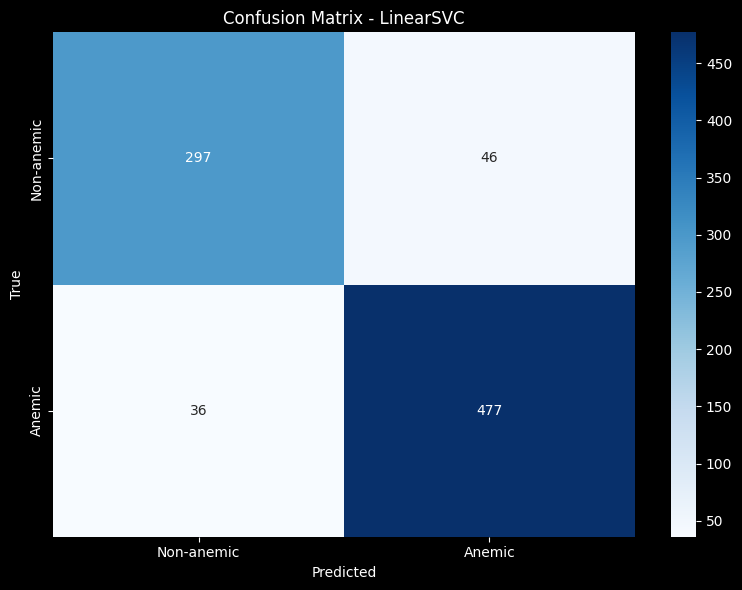


Contoh prediksi dengan probabilitas:
Sampel 1:
  Label sebenarnya: Anemic
  Prediksi: Anemic
  Probabilitas anemic: 0.8077
Sampel 2:
  Label sebenarnya: Non-anemic
  Prediksi: Non-anemic
  Probabilitas anemic: 0.1391
Sampel 3:
  Label sebenarnya: Anemic
  Prediksi: Anemic
  Probabilitas anemic: 0.6163
Sampel 4:
  Label sebenarnya: Anemic
  Prediksi: Anemic
  Probabilitas anemic: 0.5778
Sampel 5:
  Label sebenarnya: Anemic
  Prediksi: Anemic
  Probabilitas anemic: 0.8562

===== INSIGHT DAN REKOMENDASI =====
1. Model mencapai akurasi keseluruhan 90.42%
2. Kemampuan mendeteksi kasus anemia (recall): 92.98%
3. Kemampuan mendeteksi kasus non-anemia (recall): 86.59%
4. Dari kasus yang diprediksi anemia, 91.20% benar-benar anemia (precision)
5. Dari kasus yang diprediksi non-anemia, 89.19% benar-benar non-anemia (precision)

Analisis kesalahan:
- False Positives (Non-anemic diprediksi sebagai Anemic): 46 kasus
- False Negatives (Anemic diprediksi sebagai Non-anemic): 36 kasus


In [ ]:
# Import library yang dibutuhkan
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

# 1. Load model
try:
    with open('linearsvc_anemia_model.pkl', 'rb') as f:
        linear_svc = pickle.load(f)
    
    with open('calibrated_linearsvc_model.pkl', 'rb') as f:
        calibrated_svc = pickle.load(f)
except FileNotFoundError:
    print("Model belum tersedia. Jalankan implementasi model terlebih dahulu.")

# 2. Evaluasi model dengan metrik dasar
# Prediksi pada data test
y_pred = linear_svc.predict(X_test)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
report = classification_report(y_test, y_pred, target_names=['Non-anemic', 'Anemic'], output_dict=True)
print(classification_report(y_test, y_pred, target_names=['Non-anemic', 'Anemic']))

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-anemic', 'Anemic'],
            yticklabels=['Non-anemic', 'Anemic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - LinearSVC')
plt.tight_layout()
plt.savefig('confusion_matrix_linearsvc.png')
plt.show()

# 4. Evaluasi probabilistik
# Mendapatkan probabilitas menggunakan model terkalibrasi
y_proba = calibrated_svc.predict_proba(X_test)

# Menampilkan contoh prediksi dengan probabilitas
print("\nContoh prediksi dengan probabilitas:")
for i in range(5):  # Tampilkan 5 contoh
    true_label = "Anemic" if y_test[i] == 1 else "Non-anemic"
    predicted_label = "Anemic" if calibrated_svc.predict([X_test[i]])[0] == 1 else "Non-anemic"
    probability_anemic = y_proba[i][1]
    
    print(f"Sampel {i+1}:")
    print(f"  Label sebenarnya: {true_label}")
    print(f"  Prediksi: {predicted_label}")
    print(f"  Probabilitas anemic: {probability_anemic:.4f}")

# 5. Insight dan rekomendasi
print("\n===== INSIGHT DAN REKOMENDASI =====")
# Ekstrak metrik dari classification report
anemic_precision = report['Anemic']['precision']
anemic_recall = report['Anemic']['recall']
non_anemic_precision = report['Non-anemic']['precision']
non_anemic_recall = report['Non-anemic']['recall']

print(f"1. Model mencapai akurasi keseluruhan {accuracy*100:.2f}%")
print(f"2. Kemampuan mendeteksi kasus anemia (recall): {anemic_recall*100:.2f}%")
print(f"3. Kemampuan mendeteksi kasus non-anemia (recall): {non_anemic_recall*100:.2f}%")
print(f"4. Dari kasus yang diprediksi anemia, {anemic_precision*100:.2f}% benar-benar anemia (precision)")
print(f"5. Dari kasus yang diprediksi non-anemia, {non_anemic_precision*100:.2f}% benar-benar non-anemia (precision)")

# Hitung jumlah kesalahan
false_positives = cm[0, 1]  # Non-anemic diprediksi sebagai Anemic
false_negatives = cm[1, 0]  # Anemic diprediksi sebagai Non-anemic

print(f"\nAnalisis kesalahan:")
print(f"- False Positives (Non-anemic diprediksi sebagai Anemic): {false_positives} kasus")
print(f"- False Negatives (Anemic diprediksi sebagai Non-anemic): {false_negatives} kasus")


## **4. 🤩 Insight dan Kesimpulan**


#### - Insight
##### Performa Deteksi Kasus Positif Tinggi: Model menunjukkan kemampuan yang sangat baik dalam mendeteksi kasus anemia dengan recall 93%, hanya melewatkan 36 kasus dari total sampel anemia.
##### Keseimbangan Performa Antar Kelas: Meski sedikit lebih baik dalam mendeteksi kasus anemia (93%) dibanding non-anemia (87%), model tetap menunjukkan performa yang seimbang untuk kedua kelas.
##### Preferensi Model Terhadap False Positive: Model cenderung melakukan lebih banyak kesalahan false positive (46) daripada false negative (36), menunjukkan bias ke arah keamanan dalam konteks medis.
##### Efektivitas Ekstraksi Fitur Sederhana: Meski menggunakan pendekatan ekstraksi fitur yang sederhana (flatten gambar), model masih mencapai akurasi tinggi 90.4%, menunjukkan kekuatan SVM untuk data gambar medis.
##### Validasi Hasil EDA: Performa model mengkonfirmasi temuan EDA bahwa terdapat perbedaan karakteristik visual yang cukup signifikan antara gambar anemic dan non-anemic yang bisa dimanfaatkan untuk klasifikasi.



#### - Kesimpulan
##### Terdapat Potensi Sebagai Sistem Screening: Dengan sensitivitas tinggi 93% dan presisi 91%, model ini cocok digunakan sebagai alat screening awal anemia, dengan false positive dapat diarahkan untuk pemeriksaan lebih lanjut.
##### Efisiensi Komputasional: Penggunaan LinearSVC terbukti efektif dan efisien untuk klasifikasi biner gambar medis, dengan waktu training yang relatif cepat (~3 menit) untuk dataset berukuran menengah.

## **5. Referensi dan Publikasi Github**


###### Banerjee, P. (2020). Support Vector Machines Classifier Tutorial with Python. Kaggle Notebooks. Available online : https://www.kaggle.com/code/prashant111/svm-classifier-tutorial/notebook#5.-Dataset-description-

###### Saksham, K. (2022). Cat And Dog Image Classification Using SVM. Kaggle Notebooks. Available online: https://www.kaggle.com/code/everydaycodings/cat-and-dog-image-classification-using-svm#Creating-the-Model

###### Shanmukh, V. (2021, March 4). Image Classification Using Machine Learning-Support Vector Machine(SVM). Analytics Vidhya. Available Online : https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01